# RLdeconvolution by physically cutting frequencies

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import filters

from scipy import signal

In [149]:
# we load a standard image
camera = data.camera()
camera = data.shepp_logan_phantom()

camera = np.random.rand(camera.shape[0], camera.shape[1])
camera = camera<0.001

# intensity normalization
camera = np.float32(camera[1:,1:])
camera /= camera.max()

In [168]:
# kernel size and properties
kernelsize = camera.shape[0]
center = np.uint32(np.floor(kernelsize/2.))

# ideal system response
delta = np.zeros([kernelsize,kernelsize])
delta[center,center] = 1

# Gaussian optical response
psf = filters.gaussian(delta, sigma=1)

In [169]:
# blurring the signal
camera_blurred = signal.convolve(camera, psf, 'same')

In [170]:
def circularmask(h, w, center, radius=1):
    # define a radial grid.
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    # this thresholds a binary mask
    mask = (dist_from_center <= radius)
    return mask

In [171]:
mask = circularmask(kernelsize, kernelsize, [center, center], radius=200)
#mask = filters.gaussian(mask, sigma=1)

In [172]:
camera_fft = (np.fft.fft2(camera_blurred.copy()))
camera_fftaperture = camera_fft * np.fft.ifftshift(mask)

camera_aperture = np.abs(np.fft.ifft2((camera_fftaperture)))

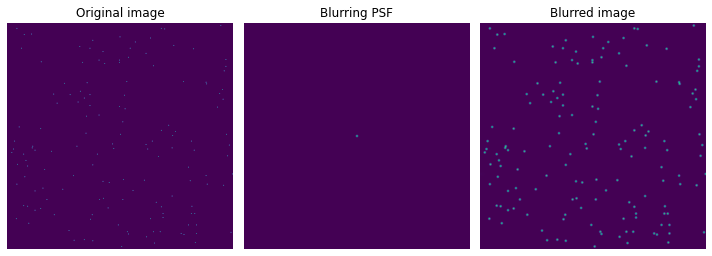

In [173]:
plt.figure(figsize=[10,10])
plt.subplot(131), plt.imshow(camera), plt.axis('off'), plt.title('Original image')
plt.subplot(132), plt.imshow(psf), plt.axis('off'), plt.title('Blurring PSF')
plt.subplot(133), plt.imshow(camera_aperture), plt.axis('off'), plt.title('Blurred image')
plt.tight_layout()

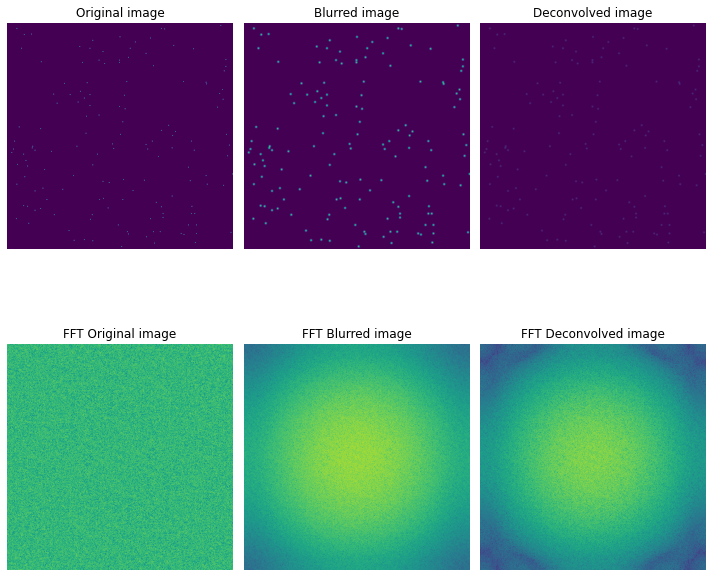

In [174]:
plt.figure(figsize=[10,10])
plt.subplot(231), plt.imshow(camera, vmin=0, vmax=1), plt.axis('off'), plt.title('Original image')
plt.subplot(232), plt.imshow(camera_blurred), plt.axis('off'), plt.title('Blurred image')
plt.subplot(233), plt.imshow(camera_aperture, vmin=0, vmax=1), plt.axis('off'), plt.title('Deconvolved image')

camera_fft_abs = np.abs(np.fft.fftshift(np.fft.fft2(camera)))
camera_blurred_fft_abs = np.abs(np.fft.fftshift(np.fft.fft2(camera_blurred)))
camera_deconvolved_fft_abs = np.abs(np.fft.fftshift(np.fft.fft2(camera_aperture)))

plt.subplot(234), plt.imshow(np.log(camera_fft_abs)), plt.axis('off'), plt.title('FFT Original image')
plt.subplot(235), plt.imshow(np.log(camera_blurred_fft_abs)), plt.axis('off'), plt.title('FFT Blurred image')
plt.subplot(236), plt.imshow(np.log(camera_deconvolved_fft_abs)), plt.axis('off'), plt.title('FFT Deconvolved image')

plt.tight_layout()

In [175]:
def euclideandistance(image1, image2):
    distance = ((image1-image2)**2).sum()
    
    return distance


def deconvolutionRL(blurred, psf, iterations=10):
    # reconstruction initialization as the blurred item
    deconvolved = blurred.copy()
    deconvolved = np.ones_like(blurred)/(blurred.shape[0]**2)
    distance = np.zeros([iterations,])
    
    for i in range(iterations): 
        # useful quantities
        forwardblur = signal.convolve(deconvolved, psf, 'same')
        ratio = blurred / forwardblur
        #deconvolved = np.maximum(ratio, 1e-6, dtype = 'float32')

        distance[i] = euclideandistance(blurred, forwardblur)
        
        # iterative update
        deconvolved *= signal.correlate(ratio, psf, 'same') 

    return deconvolved, distance

In [176]:
# frequency cutoff of a delta signal
delta_fft = np.fft.fftshift(np.fft.fft2(psf.copy()))
#delta_fftaperture = delta_fft * mask

# psf response of a circular aperture
psf_aperture = np.abs(np.fft.ifft2(np.fft.ifftshift(delta_fftaperture)))

# guarantee energy conservation
psf_aperture -= psf_aperture.min()
psf_aperture /= psf_aperture.sum()

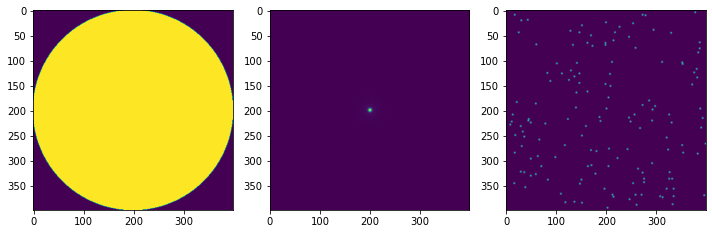

In [177]:
plt.figure(figsize=[10,10])
plt.subplot(131), plt.imshow(mask)
plt.subplot(132), plt.imshow(np.abs(psf_aperture))
plt.subplot(133), plt.imshow(np.abs(camera_aperture))
plt.tight_layout()

In [178]:
noise = np.random.rand(camera.shape[0], camera.shape[1])
alpha = 0.

# blurring the signal
camera_blurred = camera_aperture + alpha * noise

In [179]:
# running the deconvolution
camera_deconvolved, distance = deconvolutionRL(camera_aperture, psf_aperture, iterations=1000)

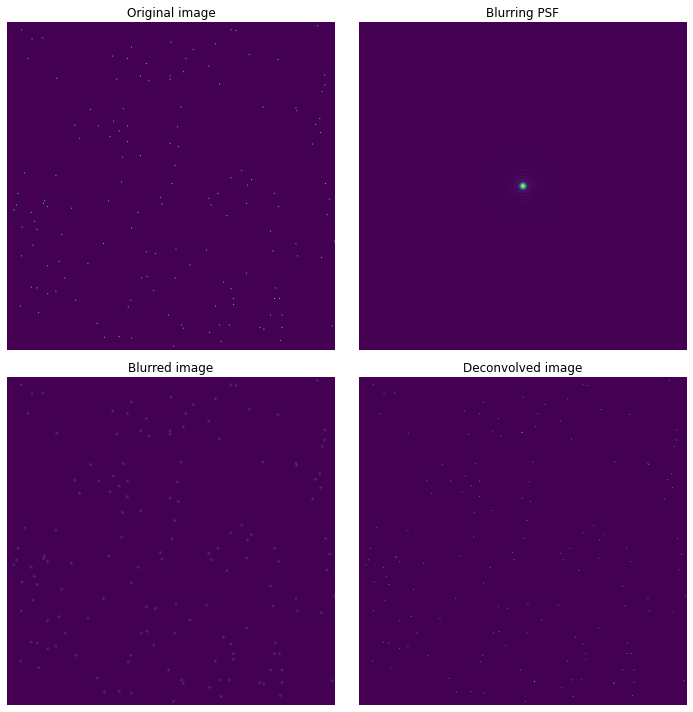

In [180]:
plt.figure(figsize=[10,10])
plt.subplot(221), 
plt.imshow(camera, vmin=0, vmax=1), plt.axis('off'), 
plt.title('Original image')

plt.subplot(222), 
plt.imshow(psf_aperture), plt.axis('off'), 
plt.title('Blurring PSF')

plt.subplot(223), 
plt.imshow(camera_aperture, vmin=0, vmax=1), plt.axis('off'),
plt.title('Blurred image')

plt.subplot(224),
plt.imshow(camera_deconvolved, vmin=0), plt.axis('off'),
plt.title('Deconvolved image')
plt.tight_layout()

Text(0, 0.5, 'Euclidean distance')

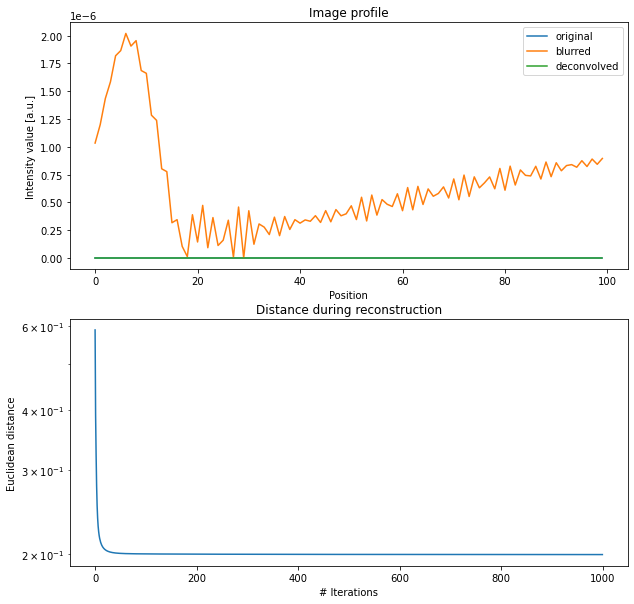

In [166]:
profile = 256
plt.figure(figsize=[10,10])

plt.subplot(211)
plt.plot(camera[profile,200:300])
plt.plot(camera_blurred[profile,200:300])
plt.plot(camera_deconvolved[profile,200:300])
plt.legend(['original', 'blurred', 'deconvolved'])
plt.title('Image profile')
plt.xlabel('Position')
plt.ylabel('Intensity value [a.u.]')

plt.subplot(212)
plt.plot(distance)
plt.yscale('log')
plt.title('Distance during reconstruction')
plt.xlabel('# Iterations')
plt.ylabel('Euclidean distance')

In [ ]:
#camera_deconvolved = deblur_core(camera_aperture, psf_aperture, iteration=100, rule=1)

In [167]:
import math
import warnings
import numpy as np
from numpy import zeros

try:
    import cupy as cp
except ImportError:
    cupy = None

xp = np


def iterative_deconv(data,kernel,iteration,rule):
    if xp is not np:
        data = xp.asarray(data)
        kernel = xp.asarray(kernel)

    if data.ndim > 2:
        data_de = xp.zeros((data.shape[0], data.shape[1],data.shape[2]), dtype = 'float32')
        for i in range(0, data.shape[0]):
            data_de[i, :, ] = (deblur_core(data[i, :,:], kernel, iteration, rule)).real
    else:
        data_de = (deblur_core(data, kernel, iteration, rule)).real

    if xp is not np:
        data_de = xp.asnumpy(data_de)

    return data_de

def deblur_core(data, kernel, iteration, rule):

    #data = cp.asnumpy(data)
    kernel = xp.array(kernel)
    kernel = kernel / sum(sum(kernel))
    kernel_initial = kernel
    [dx,dy] = data.shape

    B = math.floor(min(dx,dy)/6)
    data = xp.pad(data, [int(B),int(B)], 'edge')
    yk = data
    xk = zeros((data.shape[0], data.shape[1]), dtype = 'float32')
    vk = zeros((data.shape[0], data.shape[1]), dtype = 'float32')
    otf = psf2otf(kernel_initial, data.shape)

    if rule == 2: 
    #LandWeber deconv
        t = 1
        gamma1 = 1
        for i in range(0,iteration):

            if i == 0:
                xk_update = data

                xk = data + t*xp.fft.ifftn(xp.conj(otf)) * (xp.fft.fftn(data) - (otf *xp.fft.fftn(data)))
            else:
                gamma2 = 1/2*(4 * gamma1*gamma1 + gamma1**4)**(1/2) - gamma1**2
                beta = -gamma2 *(1 - 1 / gamma1)
                yk_update = xk + beta * (xk - xk_update)
                yk = yk_update + t * xp.fft.ifftn(xp.conj(otf) * (xp.fft.fftn(data) - (otf * xp.fft.fftn(yk_update))))
                yk = xp.maximum(yk, 1e-6, dtype = 'float32')
                gamma1 = gamma2
                xk_update = xk
                xk = yk

    elif rule == 1:
    #Richardson-Lucy deconv

        for iter in range(0, iteration):

            xk_update = xk
            rliter1 = rliter(yk, data, otf)

            xk = yk * ((xp.fft.ifftn(xp.conj(otf) * rliter1)).real) / ( (xp.fft.ifftn(xp.fft.fftn(xp.ones(data.shape)) * otf)).real)

            xk = xp.maximum(xk, 1e-6, dtype = 'float32')

            vk_update = vk

            vk =xp.maximum(xk - yk, 1e-6 , dtype = 'float32')

            if iter == 0:
                alpha = 0
                yk = xk
                yk = xp.maximum(yk, 1e-6,dtype = 'float32')
                yk = xp.array(yk)

            else:

                alpha = sum(sum(vk_update * vk))/(sum(sum(vk_update * vk_update)) + math.e)
                alpha = xp.maximum(xp.minimum(alpha, 1), 1e-6, dtype = 'float32')
               # start = time.clock()
                yk = xk + alpha * (xk - xk_update)
                yk = xp.maximum(yk, 1e-6, dtype = 'float32')
                yk[xp.isnan(yk)] = 1e-6
                #end = time.clock()
               # print(start, end)
                #K=np.isnan(yk)

    yk[yk < 0] = 0
    yk = xp.array(yk, dtype = 'float32')
    data_decon = yk[B + 0:yk.shape[0] - B, B + 0: yk.shape[1] - B]

    return data_decon

def cart2pol(x, y):
    rho = xp.sqrt(x ** 2 + y ** 2)
    phi = xp.arctan2(y, x)
    return (rho, phi)

def pol2cart(rho, phi):
    x = rho * xp.cos(phi)
    y = rho * xp.sin(phi)
    return (x, y)

def psf2otf(psf, outSize):
    psfSize = xp.array(psf.shape)
    outSize = xp.array(outSize)
    padSize = xp.array(outSize - psfSize)
    psf = xp.pad(psf, ((0, int(padSize[0])), (0, int(padSize[1]))), 'constant')
    for i in range(len(psfSize)):
        psf = xp.roll(psf, -int(psfSize[i] / 2), i)
    otf = xp.fft.fftn(psf)
    nElem = xp.prod(psfSize)
    nOps = 0
    for k in range(len(psfSize)):
        nffts = nElem / psfSize[k]
        nOps = nOps + psfSize[k] * xp.log2(psfSize[k]) * nffts
    if xp.max(xp.abs(xp.imag(otf))) / xp.max(xp.abs(otf)) <= nOps * xp.finfo(xp.float32).eps:
        otf = xp.real(otf)
    return otf

def rliter(yk,data,otf):
    rliter = xp.fft.fftn(data / xp.maximum(xp.fft.ifftn(otf * xp.fft.fftn(yk)), 1e-6))
    return rliter